In [161]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import db_builder.db_handler as dbh
import logging
from getpass import getpass

In [162]:
logging.getLogger('sqlalchemy').setLevel(logging.WARNING)

In [163]:
db_params = {
    'user': 'postgres',
    'password': getpass('Please enter DB pw'),  # enter your DB password
    'host': 'localhost',  # 'localhost' or IP address
    'port': '5432',  # '5432'
    'database': 'ttdatabase', #tensionTerminator
}

In [164]:
toolcheck = dbh.DB_Conn(db_params)
toolcheck.connect()
engine  = toolcheck.get_engine()

Connected to PostgreSQL, DB: ttdatabase


In [165]:
def table_to_df(tabel_name: str):
    return pd.read_sql_table(tabel_name, con=engine)

In [166]:
loop_df = table_to_df('loop').reset_index().set_index('id')

2023-11-21 19:53:16,111 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-11-21 19:53:16,112 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-21 19:53:16,113 INFO sqlalchemy.engine.Engine select current_schema()
2023-11-21 19:53:16,114 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-21 19:53:16,115 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-11-21 19:53:16,115 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-21 19:53:16,116 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-11-21 19:53:16,120 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

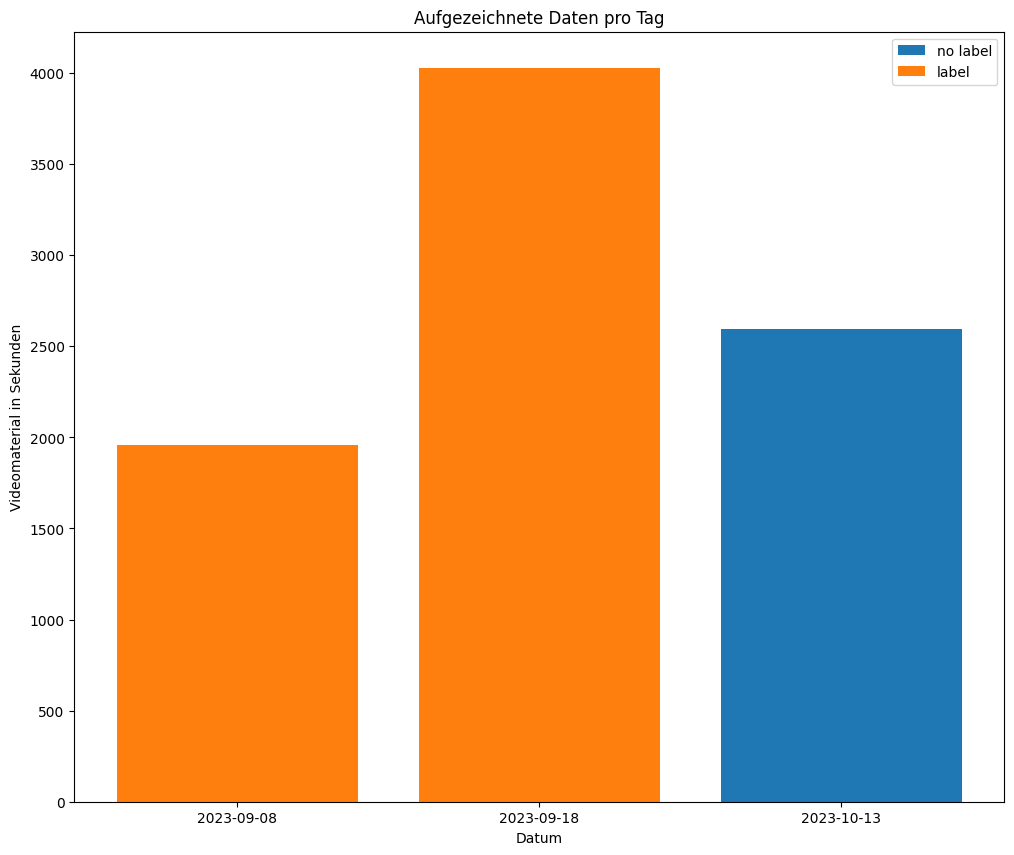

In [167]:
grouped_df = loop_df.groupby(loop_df['timestamp'].dt.date)['session_length'].sum().reset_index()
grouped_df['labeled'] = \
loop_df[loop_df['human_labeled'] == True].groupby(loop_df['timestamp'].dt.date)['session_length'].sum().reset_index()[
    'session_length']

grouped_df = grouped_df.fillna(0)
grouped_df
loop_df.loc[loop_df['human_labeled'] == True, 'session_length'].sum()
grouped_df['session_length'] / 60

label = ['label', 'no lable']
plt.figure(figsize=(12, 10))

plt.bar(grouped_df['timestamp'].astype(str), grouped_df['session_length'], label='no label')
plt.bar(grouped_df['timestamp'].astype(str), grouped_df['labeled'], label='label')
plt.xlabel('Datum')
plt.ylabel('Videomaterial in Sekunden')
plt.title('Aufgezeichnete Daten pro Tag')
#plt.ylim(0, 70)
plt.legend()

plt.savefig('overview.png')

In [168]:
def overview():
    result = (
        f"Die DB enthält {loop_df['timestamp'].count()} Aufzeichnungen, das entspricht {loop_df['session_length'].sum()} Sekunden an Videomaterial:\n"
        f"\t\t{loop_df['human_labeled'].sum()} Aufzeichnungen sind von Menschen gelabelt ({loop_df.loc[loop_df['human_labeled'] == True, 'session_length'].sum()} Sekunden)\n"
        f"\t\t{(loop_df['human_labeled'] == False).sum()} Aufzeichnungen sind ungelabelt ({loop_df.loc[loop_df['human_labeled'] == False, 'session_length'].sum()} Sekunden)\n"
        f"Videolänge mean: {loop_df['session_length'].mean()} Sekunden\n"
        f"Videolänge median: {loop_df['session_length'].median()} Sekunden\n"
        f"Videolänge min: {loop_df['session_length'].min()} Sekunden\n"
        f"Videolänge max: {loop_df['session_length'].max()} Sekunden\n"
    )
    return result


In [169]:
def output_df_to_pdf(pdf, df):
    # Calculate cell width dynamically based on column content
    table_cell_widths = {}
    for col in df.columns:
        max_length = max(df[col].astype(str).apply(len).max(), len(col))
        table_cell_widths[col] = max_length * 2.5

    
    # Set the font and size
    pdf.set_font('Arial', '', 10)
    
    # Loop over to print column names and set cell width
    for col in df.columns:
        pdf.cell(table_cell_widths[col], 6, col, align='C', border=1)
    pdf.ln(6)  # Line break
    
    # Loop over to print each data in the table
    for _, row in df.iterrows():
        for col in df.columns:
            value = str(row[col])
            pdf.cell(table_cell_widths[col], 6, value, align='C', border=1)
        pdf.ln(6)  # Line break


In [170]:
from fpdf import FPDF

# 1. Set up the PDF doc basics
pdf = FPDF()
pdf.add_page()
pdf.set_font('Courier', 'B', 16)

# 2. Layout the PDF doc contents
## Title
pdf.image('logo.png')
#pdf.ln(20)
pdf.cell(60, 10, 'TensionTerminator Datareport')
pdf.ln(20)
pdf.set_font('Courier', 'B', 10)
pdf.multi_cell(0,6, overview())
## Line breaks
#pdf.ln(40)
## Image
pdf.image('overview.png',5,100,200)
## Line breaks
pdf.ln(180)
## Show table of historical data
### Transform the DataFrame to include index of Date
loop_df_noid = loop_df
### Transform the Date column as str dtype
#output_df_to_pdf(pdf, loop_df_noid.tail(3))

output_df_to_pdf(pdf, loop_df_noid)
# 3. Output the PDF file
pdf.output('fpdf_pdf_report.pdf', 'F')

''